# Assignment 3 - Using Stan & other exercises

In [1]:
# Setup 
import numpy as np
import matplotlib.pyplot as plt
import pystan

## 1. Implement models in Stan

### 1. Call center data set

To model the call center data set we use Bayesian inference. To calculate the posterior we use an exponential likelihood with a gamma prior. We want to estimat the number of calls per minute for the 13th hour of the call center data set.

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


To remind ourselves let's look at the distribution of the waiting times per hour.

In [3]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

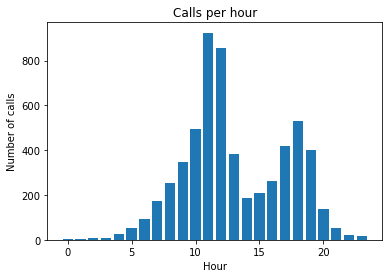

In [4]:
plt.bar(
    x = list(range(len(waiting_times_per_hour))), 
    height = [len(x) for x in waiting_times_per_hour]
)
plt.xlabel('Hour')
plt.ylabel('Number of calls')
plt.title('Calls per hour')
plt.show()

Specifically looking at the 13th hour, we can see the distribtuion of the waiting times of the 13th hour.

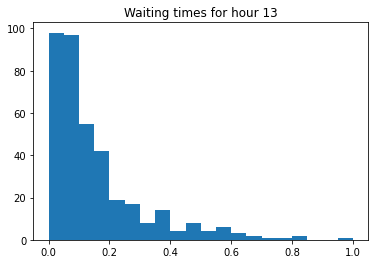

In [5]:
# Plot histogram of waiting times for hour
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

In [6]:
stan_code = '''

data {
    int <lower=1> N;   // Sample size
    vector[N] y;       // Outcome
    real alpha;        // Prior hyperparameter
    real beta;         // Prior hyperparameter
}

parameters {
    real lambda;  // the parameter for our posterior model
}

model {
    lambda ~ gamma(alpha, beta);     // Prior distribution
    y ~ exponential(lambda);         // Likelihood distribution
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1207905c5bb1a40fd000b1255d75927c NOW.


In [7]:
# Results for one row (father = 0)
stan_data = {
    'N': len(waiting_times_hour),
    'y': waiting_times_hour,
    'alpha': 1,
    'beta': 0.25
}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_1207905c5bb1a40fd000b1255d75927c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.36  8.1e-3   0.33   5.73   6.15   6.36   6.58   7.04   1653    1.0
lp__   322.56    0.02   0.74 320.45 322.42 322.86 323.02 323.08   1821    1.0

Samples were drawn using NUTS at Thu Feb 18 17:47:00 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
# The 98% percentiles
samples = results.extract()
np.percentile(samples['lambda'], [1, 99])

array([5.63365285, 7.17951561])

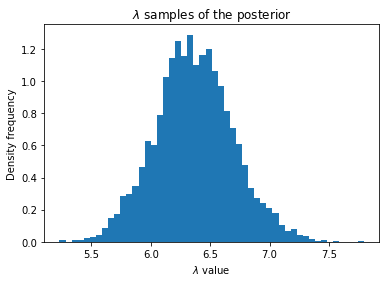

In [20]:
plt.hist(samples['lambda'], bins=50, density=True)
plt.title('$\lambda$ samples of the posterior')
plt.xlabel('$\lambda$ value')
plt.ylabel('Density frequency')
plt.show()